# Testing a difference in means

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

## Difference in means

A few days ago the [following question appeared on the statistics forum of Reddit](https://www.reddit.com/r/statistics/comments/fmfm0i/q_testing_equivalence_of_means_from_two_gamma/):

> This may be a simple question for most of you, but I’m still learning statistics and I can’t find any resource that explains how to test two sample means from gamma distributions. Both samples have n > 30, so does that mean I can use a ttest due to central limit theorem? If so, can someone please ELI15?

One of the first responses suggests:

> Look up Permutation Tests

I think this is a good suggestion, so let's do it.  Then I'll come back to the questions the original poster (OP) asked about the central limit theorem.

## Fake data

First, let's generate some fake data by sampling from two gamma distributions with different means.  

I'll set the seed for the random number generator so we get the same samples every time.

In [3]:
np.random.seed(2)

As an example, I'll assume that the actual means in the population are 2 and 3, and that the sample sizes are 30 and 40.

In [4]:
mean1, mean2 = 2, 3
size1, size2 = 30, 40

In [5]:
sample1 = np.random.gamma(mean1, size=size1)
np.mean(sample1)

1.944189047284886

In [6]:
sample2 = np.random.gamma(mean2, size=size2)
np.mean(sample2)

2.7019613323781497

**Warm-up Exercise:** Compute the difference in means between the two samples.

In [8]:
np.mean(sample1)-np.mean(sample2)

-0.7577722850932638

## Test statistic

From the statement of the problem it sounds like we have no prior reason to expect the difference in means to be positive or negative, so it is appropriate to run a two-sided test.  One way to do that is to use the absolute value of the difference in means as a test statistic.

The following function takes the two samples and returns the absolute value of the difference in their means.

In [9]:
def test_statistic(sample1, sample2):
    """Compute the test statistic.
    
    sample1: sequence of values
    sample2: sequence of values
    
    return: float
    """
    diff = np.mean(sample1) - np.mean(sample2)
    return np.abs(diff)

Here's the observed difference in the means.

In [10]:
actual_diff = test_statistic(sample1, sample2)
actual_diff

0.7577722850932638

This value is the "apparent effect"; based on these samples, it seems like there is a difference between the means of the two populations.  

But we would like to check whether it is plausible that the two populations actually have the same mean, and the apparent difference is solely due to random sampling.

## Permutation

One way to do that is by resampling or, more specifically, by permutation.  Here's the process:

1. The "null hypothesis" is that the two populations have the same mean.  Under this hypothesis, we could consider both groups to be samples from the same population, so we can merge them into a single sample.

2. To simulate the data-generating process under the null hypothesis, we can shuffle (permute) the merged sample and then split it into samples with the given sizes.

**Exercise:** Compute the probability of seeing a difference in means as big as `actual_diff` under the null hypothesis.

Use `np.concatenate` to merge the samples.  Use `np.random.shuffle` to shuffle the merged sample.  Use `np.split` to split the shuffled sample into groups with sizes `size1` and `size 2`.  Then compute the difference in means between the shuffled groups.

Repeat that process 1000 times and count the number of times the observed difference exceeds `actual_diff`.

In [18]:
sample = np.concatenate((sample1, sample2))

In [19]:
np.random.shuffle(sample)

In [44]:
s = np.split(sample, [size1])

In [45]:
s1, s2 = s[0], s[1]

In [46]:
test_statistic(s1, s2)

0.49958166682257676

In [53]:
counter = 0
for i in range(1000):
    np.random.shuffle(sample)
    s = np.split(sample, [size1])
    diff = test_statistic(s[0], s[1])
    if diff > actual_diff:
        counter += 1
counter

46

## There is only one test

The computation in the previous section is an example of a framework I call "There is Only One Test".  The idea is that all hypothesis tests have the same logical structure, shown in the following diagram:

<img src="https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/hypothesis_testing.png" width="400">

The key steps in this framework are:

1. Choose a test statistic that quantifies the observed effect.

2. Define a model of the null hypothesis and use it to generate simulated data.

3. Compute the distribution of the test statistic under the null hypothesis.

4. Compute a p-value, which is probability, under the null hypothesis, of seeing an effect as extreme as what you saw.

## Estimation

So far we've computed a p-value, which is the probability of seeing a difference in means as big as `actual_diff` under the null hypothesis, which is that both samples are actually drawn from the same population.

As I wrote in 2105, [p-values are not completely useless](http://allendowney.blogspot.com/2015/03/statistical-inference-is-only-mostly.html).  If you think an apparent effect might be due to chance, the p-value can tell you whether that's plausible.

However, p-values don't provide a lot of guidance for decision making.  For that, it is often more useful to estimate the size of the effect.  In this example, estimating the size of the difference is easy; in fact, we've already done it.  

The estimated size of the difference in means is:

In [54]:
np.mean(sample1) - np.mean(sample2)

-0.7577722850932638

This result is a "point estimate", that is, a single value that quantifies the size of the effect.

But we might wonder how precise the estimate is.  We can answer that question by computing a standard error and/or a confidence interval.

That's what we'll do in this section, and once again we'll do it by resampling.  Here are the key steps:

1. We'll use the data to build of model of the population.

2. We'll use the model to generate simulated data.

3. We'll use the simulated data to compute a sample of possible differences in the mean.

To build a model of the population, we will make an assumption that sounds strange, but actually works:

* We assume that the values in the sample represent the entire population.

Under this assumption, we can generate a new sample by choosing values from the old sample with replacement.  Here's a function that does it.

In [55]:
def resample(sample):
    """Draw a new sample from the data with replacement.
    
    sample: sequence of values
    
    returns: NumPy array
    """
    return np.random.choice(sample, len(sample), replace=True)

Notice that the size of the resampled data is the same as the size of the original sample.  As a result, the same value might appear more than once, and other values might not appear at all.

If we run `resample` many times and compute the mean of each batch of resampled data, we get a sample from the "sampling distribution of the mean", which is the distribution of means we would get if we ran the same experiment over and over.

The following function simulates the experiment 1001 times and returns a sample of possible means:

In [56]:
def sampling_distribution_of_mean(sample):
    """Simulate the sampling process and compute sample means.
    
    sample: sequence of values
    
    returns: NumPy array of means
    """
    means = [resample(sample).mean() for i in range(1001)]
    return np.array(means)

Here's what it looks like for `sample1`:

In [57]:
sample_of_means1 = sampling_distribution_of_mean(sample1)
np.mean(sample_of_means1)

1.9402325183629607

The mean of possible means is pretty close to the mean of the original sample:

In [58]:
np.mean(sample1)

1.944189047284886

That's as expected, and it doesn't tell us much we didn't know.  However, the standard deviation of the sampling distribution tells us how much we expect the sample mean to vary from one simulated experiment to the next

In [59]:
standard_error = np.std(sample_of_means1)
standard_error

0.2688790687913238

This value is the "standard error", which quantifies the precision of the estimate.  I'm using the word "precision" carefully here, because standard error doesn't tell us whether the estimate is accurate; it only tells us how precise it is.  You can [read more about the difference between precision and accuracy here](https://en.wikipedia.org/wiki/Accuracy_and_precision).

Another way to quantify precision is to compute a "confidence interval"; for example, a 90% confidence interval contains 90% of the sampling distribution.

We can use `np.percentile` to compute the interval between the 5th and 95th percentiles.

In [60]:
CI = np.percentile(sample_of_means1, [5, 95])
CI

array([1.52484323, 2.38392622])

In this example the 90% confidence interval contains the actual population mean, which is 2.  Of course, in the real world, we usually don't know the population mean.  If we did, we wouldn't be estimating it.

**Exercise:** The following cell computes the sampling distribution of the mean for `sample2`.  Compute the standard error and a 90% confidence interval.  Does the CI contain the population mean?

In [61]:
sample_of_means2 = sampling_distribution_of_mean(sample2)

In [62]:
standard_error = np.std(sample_of_means2)
standard_error

0.2559167986120326

In [63]:
CI = np.percentile(sample_of_means2, [5, 95])
CI

array([2.27747624, 3.13328324])

The CI does not contain the population mean.

**Exercise:** Estimate the sampling distribution for the difference in means by subtracting `sample_of_means1` and `sample_of_means2` elementwise.  Compute the SE and 90% CI.

In [64]:
sample_of_means = sample_of_means2-sample_of_means1

In [65]:
standard_error = np.std(sample_of_means)
standard_error

0.365758902749551

In [66]:
CI = np.percentile(sample_of_means, [5, 95])
CI

array([0.16008976, 1.38835948])

## Estimating sampling distributions

The process we used in the previous section is an example of a framework for computing sampling distributions, standard errors, and confidence intervals, as shown in the following figure:

<img src="https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/resampling.png" width="400">

The essential steps are:

1. Choose a sample statistic that quantifies the thing you want to estimate.

2. Use the data to make a model of the population.

3. Use the model to simulate the sampling process and generate simulated data.

4. Compute the sampling distribution of the estimate.

5. Use the sampling distribution to compute the standard error, confidence interval, or both.

But remember that this process only accounts for variability due to random sampling.  It doesn't tell us anything about systematic errors in the sampling process, measurement error, or other sources of error.

## The central limit theorem

Now let's get back to the original question:

> This may be a simple question for most of you, but I’m still learning statistics and I can’t find any resource that explains how to test two sample means from gamma distributions. Both samples have n > 30, so does that mean I can use a ttest due to central limit theorem? If so, can someone please ELI15?

The question is about [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) which is an analytic method for estimating p-values under certain assumptions about the distribution of the data.

Without getting into the details, the t-test is accurate enough for practical purposes as long as the sampling distribution of the mean is approximately normal (Gaussian).

If the distribution of the data is approximately normal, so is the sampling distribution of the means, so in that case there's no problem: the t-test is fine.

But what if the distribution of the data is not normal, as in this example, where we are told that the data are closer to a gamma distribution?

In that case, the t-test is usually fine anyway because of the central limit theorem, which implies that the sampling distribution of the mean is often (but not always) approximately normal even if the distribution of the data is not.

Now you might wonder: how do we know when this approximation is good enough?  Well, one way is to use resampling to estimate the sampling distribution.  So let's do that.

First, here's the distribution of the data in the two samples, represented as a CDF.

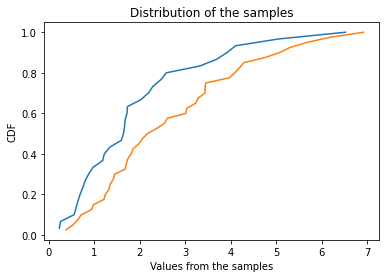

In [67]:
from empiricaldist import Cdf

cdf1 = Cdf.from_seq(sample1)
cdf1.plot(label='Sample 1')

cdf2 = Cdf.from_seq(sample2)
cdf2.plot(label='Sample 2')

plt.xlabel('Values from the samples')
plt.ylabel('CDF')
plt.title('Distribution of the samples');

In this example, the data were literally drawn from a gamma distribution, no it is no surprise that these CDFs do not look like normal distributions.

To see that more clearly, I'll compute normal distributions with the same mean and standard deviation, and we'll see how different they look.

In [68]:
from scipy.stats import norm

def plot_normal_model(sample, **options):
    """Plot the CDF of a normal distribution with the
    same mean and std of the sample.
    
    sample: sequence of values
    options: passed to plt.plot
    """
    mean, std = np.mean(sample), np.std(sample)
    xs = np.linspace(np.min(sample), np.max(sample))
    ys = norm.cdf(xs, mean, std)
    plt.plot(xs, ys, alpha=0.4, **options)

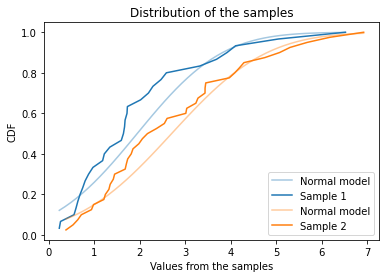

In [69]:
from empiricaldist import Cdf

plot_normal_model(sample1, color='C0', label='Normal model')
cdf1 = Cdf.from_seq(sample1)
cdf1.plot(label='Sample 1')

plot_normal_model(sample2, color='C1', label='Normal model')
cdf2 = Cdf.from_seq(sample2)
cdf2.plot(label='Sample 2')

plt.xlabel('Values from the samples')
plt.ylabel('CDF')
plt.title('Distribution of the samples')

plt.legend();

The normal model does not fit the data particularly well; in particular, the normal model implies that negative values have non-negligible probability.  But the values from a gamma distribution cannot be negative (like most quantities that we measure in the world).

But now let's do the same thing with the sampling distributions of the means:

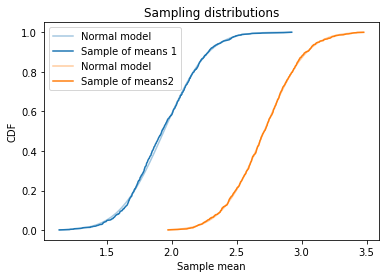

In [70]:
plot_normal_model(sample_of_means1, color='C0', label='Normal model')
cdf1 = Cdf.from_seq(sample_of_means1)
cdf1.plot(label='Sample of means 1')

plot_normal_model(sample_of_means2, color='C1', label='Normal model')
cdf2 = Cdf.from_seq(sample_of_means2)
cdf2.plot(label='Sample of means2')

plt.xlabel('Sample mean')
plt.ylabel('CDF')
plt.title('Sampling distributions')

plt.legend();

The models fit the data so well you can barely see them.  So the answer to the original question is a clear yes: with a gamma distribution and sample sizes near 30, the sampling distribution of the mean is approximately normal, the assumptions of the t-test are satisfied, and the results are accurate enough for practical purpose.

At least, for *these* gamma distributions that's true.  For other gamma distributions it might not be.  In particular, when the mean of a gamma distribution is small, its skewness is large, and we need a larger sample size to ensure that the sampling distribution is normal enough.

So how are we supposed to know?  Well, one option is to use resampling to estimate the sampling distribution.  But if we have to use resampling to know whether or not the t-test is reliable, we might as well use resampling to compute the p-value, standard error, and/or confidence interval, in my opinion.